In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Day','Hour', 'Minute', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Day','Hour', 'Minute', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [3]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp['Day'] = i
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 11), (3888, 9))

In [5]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [7]:
df_train.Hour = df_train.Hour*60 + df_train.Minute
df_test.Hour = df_test.Hour*60 + df_test.Minute

In [12]:
df_train.drop('Minute', axis=1, inplace=True)
df_test.drop('Minute', axis=1, inplace=True)

In [13]:
min = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].max()

In [14]:
for i, col in enumerate(['Day','Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [15]:
Day0 = df_train.iloc[:, :-2]
Day  = df_train.iloc[:, 1:-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

df_test0 = df_test.copy()
df_test = df_test.iloc[:, 1:]

In [16]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [17]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [19]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [20]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 2s 2ms/step - loss: 367.0124 - val_loss: 179.3990
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 171.3286 - val_loss: 157.1619
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 152.4709 - val_loss: 150.3380
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 153.6821 - val_loss: 148.4488
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 147.9465 - val_loss: 147.9791
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 149.6875 - val_loss: 151.8480
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 149.4625 - val_loss: 146.3759
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 142.1664 - val_loss: 153.1464
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 148.6954 - val_loss: 148.1889
Epoch 10/100
615/615 [==============================] -

136.28952026367188

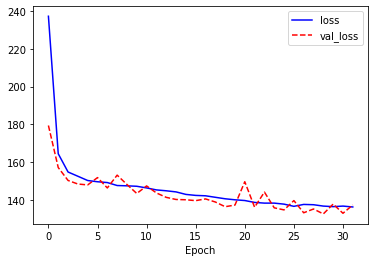

In [21]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [22]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4789 - val_loss: 1.5836
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4029 - val_loss: 1.5927
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3906 - val_loss: 1.5907
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3871 - val_loss: 1.5816
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3955 - val_loss: 1.6023
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.3909 - val_loss: 1.5898
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3957 - val_loss: 1.5844
Epoch 00007: early stopping
Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2628 - val_loss: 2.6136
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2436 - val_loss: 2.5848
Epoch 3/100
820/820 [==============================] - 1s 1ms/s

820/820 [==============================] - 2s 1ms/step - loss: 2.6474 - val_loss: 2.9943
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6240 - val_loss: 3.0029
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6239 - val_loss: 3.0017
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6275 - val_loss: 3.0450
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.3419 - val_loss: 2.6645
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3224 - val_loss: 2.6795
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3269 - val_loss: 2.7110
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3329 - val_loss: 2.6737
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 1.9180 - val_loss: 2.1735
Epoch 2/100
820/820 [==========================

820/820 [==============================] - 2s 2ms/step - loss: 0.7779 - val_loss: 0.8793
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7648 - val_loss: 0.9414
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7713 - val_loss: 0.9098
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7723 - val_loss: 0.9012
Epoch 00004: early stopping


(3888, 18)

In [23]:
from lightgbm import LGBMRegressor

In [24]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.3527
Early stopping, best iteration is:
[454]	valid_0's quantile: 1.35216
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.14965
[1000]	valid_0's quantile: 2.14175
[1500]	valid_0's quantile: 2.13476
[2000]	valid_0's quantile: 2.12701
[2500]	valid_0's quantile: 2.12587
Early stopping, best iteration is:
[2259]	valid_0's quantile: 2.12552
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.54167
[1000]	valid_0's quantile: 2.5202
[1500]	valid_0's quantile: 2.51019
[2000]	valid_0's quantile: 2.50061
[2500]	valid_0's quantile: 2.49779
[3000]	valid_0's quantile: 2.49474
[3500]	valid_0's quantile: 2.49038
[4000]	valid_0's quantile: 2.48785
[4500]	valid_0's quantile: 2.48511
[5000]	valid_0's quantile: 2.4815
[5500]	valid_0's quantile: 2.48013
[6000]	valid_0's quantile: 2.47913
Early stopping, best iteration is:
[601

In [25]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4355 - val_loss: 1.5999
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4211 - val_loss: 1.5988
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4135 - val_loss: 1.5978
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4160 - val_loss: 1.5975
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4243 - val_loss: 1.6021
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4144 - val_loss: 1.6133
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4171 - val_loss: 1.6167
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4315 - val_loss: 1.5995
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4201 - val_loss: 1.5957
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4316 - va

820/820 [==============================] - 1s 2ms/step - loss: 2.2474 - val_loss: 2.5991
Epoch 15/100
820/820 [==============================] - 1s 2ms/step - loss: 2.2469 - val_loss: 2.6078
Epoch 00015: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.8675 - val_loss: 2.1289
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8409 - val_loss: 2.1536
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8502 - val_loss: 2.1585
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.8450 - val_loss: 2.1771
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8450 - val_loss: 2.1719
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.8633 - val_loss: 2.1491
Epoch 00006: early stopping
0.8
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.3676 - val_loss: 1.5415
Epoch 2/100
820/820 [=================

(3888, 9)

In [26]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4559 - val_loss: 1.6511
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4440 - val_loss: 1.6425
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4348 - val_loss: 1.6413
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4260 - val_loss: 1.6404
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4428 - val_loss: 1.6403
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4365 - val_loss: 1.6476
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4450 - val_loss: 1.6466
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4516 - val_loss: 1.6390
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4517 - val_loss: 1.6416
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4617 - va

820/820 [==============================] - 2s 2ms/step - loss: 2.4038 - val_loss: 2.7633
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 2.4121 - val_loss: 2.8440
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 2.4210 - val_loss: 2.7496
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 2.3847 - val_loss: 2.7423
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 2.4318 - val_loss: 2.7496
Epoch 00007: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9791 - val_loss: 2.2531
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.9821 - val_loss: 2.2274
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9601 - val_loss: 2.2855
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 1.9732 - val_loss: 2.2439
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - lo

(3888, 9)

In [27]:
model = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 4s 3ms/step - loss: 666.7967 - val_loss: 380.6825
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 319.0085 - val_loss: 238.7623
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 212.8115 - val_loss: 182.8343
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 176.4677 - val_loss: 158.7836
Epoch 5/100
615/615 [==============================] - 2s 4ms/step - loss: 152.8899 - val_loss: 147.3816
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 147.1840 - val_loss: 147.1133
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 144.5898 - val_loss: 139.0267
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 136.6093 - val_loss: 138.8982
Epoch 9/100
615/615 [==============================] - 2s 3ms/step - loss: 140.9198 - val_loss: 138.0752
Epoch 10/100
615/615 [==============================] -

In [28]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5274 - val_loss: 1.6272
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4354 - val_loss: 1.6124
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4228 - val_loss: 1.6043
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4114 - val_loss: 1.5965
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4164 - val_loss: 1.5909
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4027 - val_loss: 1.6111
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4038 - val_loss: 1.5924
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4176 - val_loss: 1.5818
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3992 - val_loss: 1.5799
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4216 - va

Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6119 - val_loss: 2.9909
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6092 - val_loss: 2.9935
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5869 - val_loss: 2.9911
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6239 - val_loss: 2.9796
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6143 - val_loss: 3.0108
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6203 - val_loss: 2.9823
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6502 - val_loss: 2.9876
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5989 - val_loss: 2.9798
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6607 - val_loss: 2.9788
Epoch 11/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5554 - val_l

820/820 [==============================] - 3s 3ms/step - loss: 2.5291 - val_loss: 2.8940
Epoch 26/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5299 - val_loss: 2.9340
Epoch 27/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5726 - val_loss: 2.8829
Epoch 28/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5408 - val_loss: 2.9285
Epoch 29/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5412 - val_loss: 2.9907
Epoch 00029: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.2788 - val_loss: 2.5879
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2421 - val_loss: 2.5734
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2487 - val_loss: 2.5956
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2377 - val_loss: 2.6121
Epoch 5/100
820/820 [==============================] - 3s 3ms/step 

820/820 [==============================] - 6s 4ms/step - loss: 0.7527 - val_loss: 0.8482
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7371 - val_loss: 0.8624
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7460 - val_loss: 0.8697
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7432 - val_loss: 0.8646
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7387 - val_loss: 0.8785
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7454 - val_loss: 0.8547
Epoch 00006: early stopping


(3888, 9)

In [29]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8.shape

0.1
Epoch 1/100
820/820 [==============================] - 5s 3ms/step - loss: 1.5319 - val_loss: 1.6278
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4360 - val_loss: 1.6120
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4236 - val_loss: 1.6051
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4126 - val_loss: 1.5977
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4172 - val_loss: 1.5908
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4027 - val_loss: 1.6142
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4048 - val_loss: 1.5922
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4185 - val_loss: 1.5818
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4009 - val_loss: 1.5778
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4224 - va

820/820 [==============================] - 3s 3ms/step - loss: 2.6101 - val_loss: 2.9977
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5853 - val_loss: 3.0020
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6271 - val_loss: 2.9804
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6153 - val_loss: 3.0221
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6221 - val_loss: 2.9937
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6515 - val_loss: 2.9913
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5971 - val_loss: 2.9850
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6590 - val_loss: 2.9799
Epoch 11/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5538 - val_loss: 3.0036
Epoch 12/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5618 - val_loss: 2.9805

820/820 [==============================] - 3s 3ms/step - loss: 2.3155 - val_loss: 2.6205
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3669 - val_loss: 2.5858
Epoch 11/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2699 - val_loss: 2.5951
Epoch 12/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2722 - val_loss: 2.5921
Epoch 13/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3010 - val_loss: 2.6364
Epoch 14/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2831 - val_loss: 2.5755
Epoch 15/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2844 - val_loss: 2.5747
Epoch 16/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2662 - val_loss: 2.5716
Epoch 17/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2973 - val_loss: 2.5665
Epoch 18/100
820/820 [==============================] - 3s 3ms/step - loss: 2.2915 - val_loss: 

820/820 [==============================] - 3s 3ms/step - loss: 0.7491 - val_loss: 0.8632
Epoch 00006: early stopping


(3888, 9)

In [30]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day0).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test0).reshape(3888, 1, 8)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7.shape

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 1.5501 - val_loss: 1.6353
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4423 - val_loss: 1.6149
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4244 - val_loss: 1.6096
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4095 - val_loss: 1.6377
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4130 - val_loss: 1.5904
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3965 - val_loss: 1.6544
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3975 - val_loss: 1.6260
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4108 - val_loss: 1.6097
Epoch 00008: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.3269 - val_loss: 2.6016
Epoch 2/100
820/820 [==============================] - 

0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.6897 - val_loss: 2.9868
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6459 - val_loss: 2.9676
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6356 - val_loss: 2.9764
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6360 - val_loss: 2.9809
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6563 - val_loss: 2.9957
Epoch 00005: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 2.4285 - val_loss: 2.6991
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3905 - val_loss: 2.6924
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3815 - val_loss: 2.6875
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3785 - val_loss: 2.7658
Epoch 5/100
820/820 [==============================] - 

820/820 [==============================] - 5s 4ms/step - loss: 0.8483 - val_loss: 0.9494
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8287 - val_loss: 0.9539
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8365 - val_loss: 0.9516
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8339 - val_loss: 0.9630
Epoch 00004: early stopping


(3888, 9)

In [31]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day0).reshape(52464, 1, 8), np.array(Day8).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test0).reshape(3888, 1, 8)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 1.5576 - val_loss: 1.6494
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4542 - val_loss: 1.6525
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4306 - val_loss: 1.6569
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4182 - val_loss: 1.6303
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4287 - val_loss: 1.6607
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4173 - val_loss: 1.6491
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4237 - val_loss: 1.6618
Epoch 00007: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.4311 - val_loss: 2.7436
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.3802 - val_loss: 2.7070
Epoch 3/100
820/820 [==============================] - 

820/820 [==============================] - 3s 3ms/step - loss: 2.9367 - val_loss: 3.2897
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9144 - val_loss: 3.3180
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9589 - val_loss: 3.2969
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9476 - val_loss: 3.5459
Epoch 00008: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 2.8729 - val_loss: 3.2143
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 2.8404 - val_loss: 3.1911
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8302 - val_loss: 3.2014
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8312 - val_loss: 3.2239
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.8384 - val_loss: 3.2025
Epoch 00005: early stopping
0.6
Epoch 1/100
820/820 [==================

820/820 [==============================] - 6s 4ms/step - loss: 1.5352 - val_loss: 1.7288
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5120 - val_loss: 1.7186
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5122 - val_loss: 1.7514
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5108 - val_loss: 1.7037
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5165 - val_loss: 1.7376
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4884 - val_loss: 1.6877
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5150 - val_loss: 1.7073
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5052 - val_loss: 1.7147
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4811 - val_loss: 1.6717
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4950 - val_loss: 1.6771
E

In [32]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_1.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [33]:
res_0 = pd.DataFrame()
res_0res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [34]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [35]:
res_0[:48]#.to_csv('0.csv', index=False)

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [36]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [37]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
submission.to_csv('./submission/submission_20210123-1.csv', index=False)